# Case study 3 - Triangulating causal estimates with literature evidence

The biomedical literature contains a wealth of information than far exceeds our capacity for systematic manual extraction. For this reason, there are many existing literature mining methods to extract the key concepts and content. Here we use data from [SemMedDB](https://skr3.nlm.nih.gov/SemMedDB/), a well established database that provides subject-predicate-object triples from all PubMed titles and abstracts. Using a subset of this data we created MELODI-presto (https://melodi-presto.mrcieu.ac.uk/), a method to assign triples to any given biomedical query via a PubMed search and some basic enrichment, and have applied this systematically to traits represented in EpiGraphDB. This allows us to identify overlapping terms connecting any set of GWAS traits, e.g. exposure and disease outcome. From here we can attempt to triangulate causal estimates, and conversely, check the mechanisms identified from the literature against the causal evidence. 

This case study goes as follows:

- For an exposure trait we identify its causal evidence against other outcome traits,
  then link the outcomes to diseases
- Then for an exposure-outcome pair we look for its literature evidence,
  and the mechanisms (as SemMed triples) identified from the literature evidence
- Finally we look into detail the mechanisms specifically related to an overlapping term and visualise these mechanisms.

In [1]:
import json
import networkx as nx
from networkx.drawing.nx_pydot import graphviz_layout
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import requests
import math
import seaborn as sns

In [2]:
# Default parameters
API_URL = "https://api.epigraphdb.org"

In [3]:
# Parameters
API_URL = "http://dev-api.epigraphdb.org"

In [4]:
print(API_URL)
requests.get(f"{API_URL}/ping").json()

http://dev-api.epigraphdb.org


True

## Parameters

Here we set the starting trait, which we will use to explore associated disease traits.

In [5]:
STARTING_TRAIT = "Sleep duration"

## Get traits MR association 

Given an exposure trait, find all traits with causal evidence. This method searches the causal evidence data for cases where our exposure trait has a potential casual effect on an outcome trait. 

In [6]:
def get_mr(trait):
    endpoint = "/mr"
    url = f"{API_URL}{endpoint}"
    params = {
        "exposure_trait": trait,
        "pval_threshold": 1e-10,
    }
    r = requests.get(url, params=params)
    r.raise_for_status()
    mr_df = pd.json_normalize(r.json()["results"])
    return mr_df


mr_df = get_mr(STARTING_TRAIT)
print(mr_df.info())
mr_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1178 entries, 0 to 1177
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   exposure.id     1178 non-null   object 
 1   exposure.trait  1178 non-null   object 
 2   outcome.id      1178 non-null   object 
 3   outcome.trait   1178 non-null   object 
 4   mr.b            1178 non-null   float64
 5   mr.se           1178 non-null   float64
 6   mr.pval         1178 non-null   float64
 7   mr.method       1178 non-null   object 
 8   mr.selection    1178 non-null   object 
 9   mr.moescore     1178 non-null   float64
dtypes: float64(4), object(6)
memory usage: 92.2+ KB
None


,exposure.id,exposure.trait,outcome.id,outcome.trait,mr.b,mr.se,mr.pval,mr.method,mr.selection,mr.moescore
0,ieu-a-1088,Sleep duration,met-a-353,Cortisol,0.059177,0.001386,0.0,FE IVW,DF,1.0
1,ieu-a-1088,Sleep duration,met-a-307,Cholesterol,-0.024282,0.000054,0.0,FE IVW,DF,1.0
2,ieu-a-1088,Sleep duration,ieu-a-99,Hip circumference,-0.288662,0.005928,0.0,FE IVW,DF,1.0
3,ieu-a-1088,Sleep duration,ieu-a-59,Hip circumference,0.072874,0.000162,0.0,FE IVW,DF,1.0
4,ieu-a-1088,Sleep duration,ieu-a-58,Hip circumference,0.072874,0.000162,0.0,FE IVW,DF,1.0


## Map outcome traits to disease

For this example, we are interested in traits mapped to a disease node. To do this we utilise the mapping from GWAS trait to Disease via EFO term. 

In [7]:
def trait_to_disease(row):
    endpoint = "/ontology/gwas-efo-disease"
    url = f"{API_URL}{endpoint}"
    params = {
        "trait": row["outcome.trait"],
    }
    r = requests.get(url, params=params)
    r.raise_for_status()
    disease_df = pd.json_normalize(r.json()["results"])
    if "disease.label" in disease_df:
        return disease_df["disease.label"].drop_duplicates()


outcome_disease_df = (
    mr_df[["outcome.trait"]]
    .drop_duplicates()
    .assign(disease=lambda df: df.apply(trait_to_disease, axis=1))
    .dropna()
    .reset_index(drop=True)
)
outcome_disease_df

,outcome.trait,disease
0,Alzheimer's disease,[Alzheimer disease]
1,"Non-cancer illness code, self-reported: mening...","[bacterial meningitis, infectious meningitis, ..."
2,Diagnoses - secondary ICD10: K30 Dyspepsia,[dyspepsia]
3,Anorexia Nervosa,[anorexia nervosa]
4,Lymphomas,"[Burkitt lymphoma, lymphoma]"
5,Parkinson's disease,[Parkinson disease]
6,Cardioembolic stroke,[stroke disorder]
7,Non-cancer illness code self-reported: gout,[gout]
8,Insomnia complaints,[insomnia (disease)]
9,"Cancer code, self-reported: cervical cancer",[cancer]


## Take one example to look for literature evidence

For the multiple `exposure -> outcome` relationships as reported from the table above,
here we look at the literature evidence for one pair in detail:

- Trait X: "Sleep duration" 
  ([ieu-a-1088](https://gwas.mrcieu.ac.uk/datasets/ieu-a-1088/)) 
- Trait Y: "Coronary heart disease" 
  ([ieu-a-6](https://gwas.mrcieu.ac.uk/datasets/ieu-a-6/)). 

The following looks for enriched triples of information (Subject-Predicate-Object) associated with our two traits. These have been derived via PubMed searches and corresponding [SemMedDB](https://skr3.nlm.nih.gov/SemMedDB/) data. 

In [8]:
def get_gwas_pair_literature(gwas_id, assoc_gwas_id):
    endpoint = "/literature/gwas/pairwise"
    url = f"{API_URL}{endpoint}"
    params = {
        "gwas_id": gwas_id,
        "assoc_gwas_id": assoc_gwas_id,
        "by_gwas_id": "true",
        "pval_threshold": 1e-1,
        "semmantic_types": ["nusq", "dsyn"],
        "blacklist": "True",
        "limit": 1000,
    }
    r = requests.get(url, params=params)
    r.raise_for_status()
    lit_df = pd.json_normalize(r.json()["results"])
    return lit_df


GWAS_ID_X = "ieu-a-1088"
GWAS_ID_Y = "ieu-a-6"
lit_df = get_gwas_pair_literature(GWAS_ID_X, GWAS_ID_Y)

# Predicate counts for SemMed triples for trait X
print(lit_df["s1.predicate"].value_counts())
# Predicate counts for SemMed triples for trait Y
print(lit_df["s2.predicate"].value_counts())

lit_df.head()

INTERACTS_WITH        719
STIMULATES             96
INHIBITS               93
NEG_INTERACTS_WITH     51
higher_than            23
COEXISTS_WITH          15
NEG_INHIBITS            3
Name: s1.predicate, dtype: int64
TREATS                 191
STIMULATES             132
CAUSES                 120
PREVENTS               117
ASSOCIATED_WITH        103
PREDISPOSES             83
AFFECTS                 71
INTERACTS_WITH          62
INHIBITS                47
COEXISTS_WITH           34
DISRUPTS                19
NEG_PREVENTS            13
higher_than              4
AUGMENTS                 2
same_as                  1
NEG_ASSOCIATED_WITH      1
Name: s2.predicate, dtype: int64


,gwas.id,gwas.trait,gs1.pval,gs1.localCount,st1.name,s1.id,s1.subject_id,s1.object_id,s1.predicate,st.name,st.type,s2.id,s2.subject_id,s2.object_id,s2.predicate,gs2.pval,gs2.localCount,st2.name,assoc_gwas.id,assoc_gwas.trait
0,ieu-a-1088,Sleep duration,0.000095,2,Sulpiride,C0038803:INTERACTS_WITH:C0003596,C0038803,C0003596,INTERACTS_WITH,Apomorphine,"[orch, phsu]",C0003596:TREATS:C0242350,C0003596,C0242350,TREATS,0.045878,3,Erectile dysfunction,ieu-a-6,Coronary heart disease
1,ieu-a-1088,Sleep duration,0.000002,2,Glycine,C0017890:STIMULATES:C0033487,C0017890,C0033487,STIMULATES,propofol,"[orch, phsu]",C0033487:AUGMENTS:C0151744,C0033487,C0151744,AUGMENTS,0.002682,2,Myocardial Ischemia,ieu-a-6,Coronary heart disease
2,ieu-a-1088,Sleep duration,0.000002,2,Glycine,C0017890:STIMULATES:C0033487,C0017890,C0033487,STIMULATES,propofol,"[orch, phsu]",C0033487:TREATS:C0010054,C0033487,C0010054,TREATS,0.001627,2,Coronary Arteriosclerosis,ieu-a-6,Coronary heart disease
3,ieu-a-1088,Sleep duration,0.000019,2,gamma-aminobutyric acid,C0016904:STIMULATES:C0033487,C0016904,C0033487,STIMULATES,propofol,"[orch, phsu]",C0033487:AUGMENTS:C0151744,C0033487,C0151744,AUGMENTS,0.002682,2,Myocardial Ischemia,ieu-a-6,Coronary heart disease
4,ieu-a-1088,Sleep duration,0.000019,2,gamma-aminobutyric acid,C0016904:STIMULATES:C0033487,C0016904,C0033487,STIMULATES,propofol,"[orch, phsu]",C0033487:TREATS:C0010054,C0033487,C0010054,TREATS,0.001627,2,Coronary Arteriosclerosis,ieu-a-6,Coronary heart disease


### Filter the data by predicates

Sometimes it is preferable to filter the SemMedDB data, e.g. to remove less informative Predicates, such as `COEXISTS_WITH` and `ASSOCIATED_WITH`.

In [9]:
# filter out some predicates that are not informative
pred_filter = ["COEXISTS_WITH", "ASSOCIATED_WITH"]

lit_df_filter = lit_df[
    ~lit_df["s1.predicate"].isin(pred_filter)
    & ~lit_df["s2.predicate"].isin(pred_filter)
]
print(lit_df_filter["s1.predicate"].value_counts())
print(lit_df_filter["s2.predicate"].value_counts())

keep_columns = ["st1.name", "s1.predicate", "st.name", "s2.predicate", "st2.name"]
(
    lit_df_filter.sort_values(["gs1.pval", "gs2.pval"], ascending=True)
    .head(n=10)
    .reset_index(drop=True)[keep_columns]
)

INTERACTS_WITH        649
INHIBITS               87
STIMULATES             66
NEG_INTERACTS_WITH     26
higher_than            22
Name: s1.predicate, dtype: int64
TREATS                 180
STIMULATES             132
CAUSES                 120
PREVENTS               117
PREDISPOSES             83
AFFECTS                 70
INTERACTS_WITH          62
INHIBITS                46
DISRUPTS                19
NEG_PREVENTS            13
higher_than              4
AUGMENTS                 2
same_as                  1
NEG_ASSOCIATED_WITH      1
Name: s2.predicate, dtype: int64


,st1.name,s1.predicate,st.name,s2.predicate,st2.name
0,felbamate,INTERACTS_WITH,ethanol,PREVENTS,Coronary heart disease
1,Corticosterone,NEG_INTERACTS_WITH,leptin,TREATS,Coronary Arteriosclerosis
2,felbamate,INTERACTS_WITH,ethanol,AFFECTS,Coronary heart disease
3,aspirin,INHIBITS,Oral anticoagulants,TREATS,Coronary Arteriosclerosis
4,Corticosterone,NEG_INTERACTS_WITH,leptin,PREDISPOSES,Coronary heart disease
5,felbamate,INTERACTS_WITH,ethanol,TREATS,Coronary heart disease
6,Corticosterone,NEG_INTERACTS_WITH,leptin,TREATS,Coronary heart disease
7,felbamate,INTERACTS_WITH,ethanol,PREVENTS,Coronary Arteriosclerosis
8,felbamate,INTERACTS_WITH,ethanol,PREDISPOSES,Coronary heart disease
9,Corticosterone,NEG_INTERACTS_WITH,leptin,PREDISPOSES,Coronary Arteriosclerosis


## Literature results

If we explore the full table in ```lit_df_filter```, we can see lots of links between the two traits, pinned on specific overlapping terms.

We can summarise the [SemMedDB semantic type](https://mmtx.nlm.nih.gov/MMTx/semanticTypes.shtml) and number of overlapping terms:

In [10]:
lit_counts = lit_df_filter["st.name"].value_counts()
lit_counts

ethanol                                 571
melatonin                                88
agonists                                 31
leptin                                   26
Oral anticoagulants                      24
Metoprolol                               20
Antidepressive Agents                    12
Anesthetics                               8
morphine                                  7
Cytochrome P450                           6
Somatotropin                              6
Medroxyprogesterone 17-Acetate            5
propofol                                  4
Hormones                                  4
mitogen-activated protein kinase p38      4
Benzodiazepines                           4
Glycoproteins                             3
AIMP2                                     2
MAPK14                                    2
CRK                                       2
MAPK1                                     2
GRAP2                                     2
Protein Kinase C                

Note, the SemMedDB semantic types have been pre-filtered to only include a subset of possibilities. 

Further examples of these term IDs and descriptions can be found here - [https://metamap.nlm.nih.gov/Docs/SemanticTypes_2018AB.txt](https://metamap.nlm.nih.gov/Docs/SemanticTypes_2018AB.txt)

#### Plotting the overlapping term frequencies

We can also visualise the above table as a bar chart. In this case we will remove Ethanol as it is an outlier.

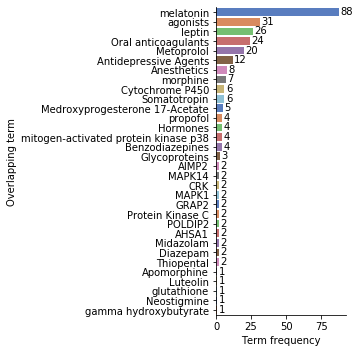

In [11]:
# remove Ethanol
lit_counts = lit_counts[lit_counts < 100]

# convert to df
lit_counts = lit_counts.reset_index(name="counts").rename(columns={"index": "st.name"})

g = sns.catplot(
    y="st.name",
    x="counts",
    data=lit_counts,
    height=5,
    kind="bar",
    palette="muted",
    orient="horizontal",
    dodge=False,
)
# add numbers to the bars
for i, v in enumerate(lit_counts["counts"]):
    plt.text(v + 1, i + 0.25, str(v))
g.set(ylabel="Overlapping term", xlabel="Term frequency")
plt.savefig("overlaps.png", dpi=1000)

## Look in detail at one overlapping term

Here we look at cases where `leptin` is the central overlapping term.

In [12]:
focus_term = "leptin"
lit_detail = lit_df_filter[lit_df_filter["st.name"] == focus_term]
lit_detail.head(n=10)

,gwas.id,gwas.trait,gs1.pval,gs1.localCount,st1.name,s1.id,s1.subject_id,s1.object_id,s1.predicate,st.name,st.type,s2.id,s2.subject_id,s2.object_id,s2.predicate,gs2.pval,gs2.localCount,st2.name,assoc_gwas.id,assoc_gwas.trait
746,ieu-a-1088,Sleep duration,0.000002,2,Corticosterone,C0010124:NEG_INTERACTS_WITH:C0299583,C0010124,C0299583,NEG_INTERACTS_WITH,leptin,"[aapp, gngm, horm]",C0299583:TREATS:C0520679,C0299583,C0520679,TREATS,0.055690,2,"Sleep Apnea, Obstructive",ieu-a-6,Coronary heart disease
748,ieu-a-1088,Sleep duration,0.000002,2,Corticosterone,C0010124:NEG_INTERACTS_WITH:C0299583,C0010124,C0299583,NEG_INTERACTS_WITH,leptin,"[aapp, gngm, horm]",C0299583:STIMULATES:C0031727,C0299583,C0031727,STIMULATES,0.009237,2,Phosphotransferases,ieu-a-6,Coronary heart disease
749,ieu-a-1088,Sleep duration,0.000002,2,Corticosterone,C0010124:NEG_INTERACTS_WITH:C0299583,C0010124,C0299583,NEG_INTERACTS_WITH,leptin,"[aapp, gngm, horm]",C0299583:STIMULATES:3717,C0299583,3717,STIMULATES,0.031956,2,JAK2,ieu-a-6,Coronary heart disease
750,ieu-a-1088,Sleep duration,0.000002,2,Corticosterone,C0010124:NEG_INTERACTS_WITH:C0299583,C0010124,C0299583,NEG_INTERACTS_WITH,leptin,"[aapp, gngm, horm]",C0299583:STIMULATES:C0169661,C0299583,C0169661,STIMULATES,0.031956,2,Janus kinase 2,ieu-a-6,Coronary heart disease
751,ieu-a-1088,Sleep duration,0.000002,2,Corticosterone,C0010124:NEG_INTERACTS_WITH:C0299583,C0010124,C0299583,NEG_INTERACTS_WITH,leptin,"[aapp, gngm, horm]",C0299583:INTERACTS_WITH:C0021641,C0299583,C0021641,INTERACTS_WITH,0.078833,2,Insulin,ieu-a-6,Coronary heart disease
754,ieu-a-1088,Sleep duration,0.000002,2,Corticosterone,C0010124:NEG_INTERACTS_WITH:C0299583,C0010124,C0299583,NEG_INTERACTS_WITH,leptin,"[aapp, gngm, horm]",C0299583:STIMULATES:C0389071,C0299583,C0389071,STIMULATES,0.073994,2,Adiponectin,ieu-a-6,Coronary heart disease
758,ieu-a-1088,Sleep duration,0.000002,2,Corticosterone,C0010124:NEG_INTERACTS_WITH:C0299583,C0010124,C0299583,NEG_INTERACTS_WITH,leptin,"[aapp, gngm, horm]",C0299583:PREDISPOSES:C0010068,C0299583,C0010068,PREDISPOSES,0.001627,2,Coronary heart disease,ieu-a-6,Coronary heart disease
760,ieu-a-1088,Sleep duration,0.000002,2,Corticosterone,C0010124:NEG_INTERACTS_WITH:C0299583,C0010124,C0299583,NEG_INTERACTS_WITH,leptin,"[aapp, gngm, horm]",C0299583:INTERACTS_WITH:C0751973,C0299583,C0751973,INTERACTS_WITH,0.001627,2,Proteome,ieu-a-6,Coronary heart disease
761,ieu-a-1088,Sleep duration,0.000002,2,Corticosterone,C0010124:NEG_INTERACTS_WITH:C0299583,C0010124,C0299583,NEG_INTERACTS_WITH,leptin,"[aapp, gngm, horm]",C0299583:CAUSES:C0856169,C0299583,C0856169,CAUSES,0.016383,2,Endothelial dysfunction,ieu-a-6,Coronary heart disease
763,ieu-a-1088,Sleep duration,0.000002,2,Corticosterone,C0010124:NEG_INTERACTS_WITH:C0299583,C0010124,C0299583,NEG_INTERACTS_WITH,leptin,"[aapp, gngm, horm]",C0299583:PREDISPOSES:C0007222,C0299583,C0007222,PREDISPOSES,0.099101,2,Cardiovascular Diseases,ieu-a-6,Coronary heart disease


We can create a network diagram to visualise these relationships.

In [13]:
# set things up
exposure = "Sleep duration".upper()
outcome = "Coronary heart disease".upper()
lit_detail.loc[:, "gwas.trait"] = lit_detail["gwas.trait"].apply(lambda x: x.upper())
lit_detail.loc[:, "assoc_gwas.trait"] = lit_detail["assoc_gwas.trait"].apply(
    lambda x: x.upper()
)
print(lit_detail.head())

        gwas.id      gwas.trait  gs1.pval  gs1.localCount        st1.name  \
746  ieu-a-1088  SLEEP DURATION  0.000002               2  Corticosterone   
748  ieu-a-1088  SLEEP DURATION  0.000002               2  Corticosterone   
749  ieu-a-1088  SLEEP DURATION  0.000002               2  Corticosterone   
750  ieu-a-1088  SLEEP DURATION  0.000002               2  Corticosterone   
751  ieu-a-1088  SLEEP DURATION  0.000002               2  Corticosterone   

                                    s1.id s1.subject_id s1.object_id  \
746  C0010124:NEG_INTERACTS_WITH:C0299583      C0010124     C0299583   
748  C0010124:NEG_INTERACTS_WITH:C0299583      C0010124     C0299583   
749  C0010124:NEG_INTERACTS_WITH:C0299583      C0010124     C0299583   
750  C0010124:NEG_INTERACTS_WITH:C0299583      C0010124     C0299583   
751  C0010124:NEG_INTERACTS_WITH:C0299583      C0010124     C0299583   

           s1.predicate st.name             st.type  \
746  NEG_INTERACTS_WITH  leptin  [aapp, gngm, hor

/home/yiliu/.local/share/virtualenvs/epigraphdb-notebooks/lib/python3.7/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [14]:
# nodes
nodes = (
    pd.concat(
        [
            # exposure trait
            lit_detail[["gwas.trait"]]
            .rename(columns={"gwas.trait": "node"})
            .assign(node_type="trait"),
            # outcome trait
            lit_detail[["assoc_gwas.trait"]]
            .rename(columns={"assoc_gwas.trait": "node"})
            .assign(node_type="trait"),
            # subject nodes
            lit_detail[["st1.name"]]
            .rename(columns={"st1.name": "node"})
            .assign(node_type="literature_term"),
            # object nodes
            lit_detail[["st2.name"]]
            .rename(columns={"st2.name": "node"})
            .assign(node_type="literature_term"),
            # overlapping term nodes
            lit_detail[["st.name"]]
            .rename(columns={"st.name": "node"})
            .assign(node_type="overlapping_term"),
        ]
    )
    .drop_duplicates()
    .reset_index(drop=True)
)
nodes

,node,node_type
0,SLEEP DURATION,trait
1,CORONARY HEART DISEASE,trait
2,Corticosterone,literature_term
3,"Sleep Apnea, Obstructive",literature_term
4,Phosphotransferases,literature_term
5,JAK2,literature_term
6,Janus kinase 2,literature_term
7,Insulin,literature_term
8,Adiponectin,literature_term
9,Coronary heart disease,literature_term


In [15]:
edges = (
    pd.concat(
        [
            # exposure -> s1 subject
            lit_detail.rename(
                columns={"gwas.trait": "source", "st1.name": "target"}
            ).assign(label="", weight=1.0)[["source", "target", "label", "weight"]],
            # s2 object -> outcome
            lit_detail.rename(
                columns={"st2.name": "source", "assoc_gwas.trait": "target"}
            ).assign(label="", weight=1.0)[["source", "target", "label", "weight"]],
            # s1 subject - s1 predicate -> st
            lit_detail.rename(
                columns={"st1.name": "source", "st.name": "target"}
            ).assign(
                label=lambda df: df.apply(
                    lambda row: f"{row['s1.predicate']}({row['gs1.localCount']}, {row['gs1.pval']:.3g})",
                    axis=1,
                ),
                weight=lambda df: df["gs1.pval"].apply(lambda x: math.log10(x) * -1),
            )[
                ["source", "target", "label", "weight"]
            ],
            # st - s2 predicate -> s2 name
            lit_detail.rename(
                columns={"st.name": "source", "st2.name": "target"}
            ).assign(
                label=lambda df: df.apply(
                    lambda row: f"{row['s2.predicate']}({row['gs2.localCount']}, {row['gs2.pval']:.3g})",
                    axis=1,
                ),
                weight=lambda df: df["gs2.pval"].apply(lambda x: math.log10(x) * -1),
            )[
                ["source", "target", "label", "weight"]
            ],
        ]
    )
    .drop_duplicates()
    .reset_index(drop=True)
)
edges

,source,target,label,weight
0,SLEEP DURATION,Corticosterone,,1.000000
1,"Sleep Apnea, Obstructive",CORONARY HEART DISEASE,,1.000000
2,Phosphotransferases,CORONARY HEART DISEASE,,1.000000
3,JAK2,CORONARY HEART DISEASE,,1.000000
4,Janus kinase 2,CORONARY HEART DISEASE,,1.000000
5,Insulin,CORONARY HEART DISEASE,,1.000000
6,Adiponectin,CORONARY HEART DISEASE,,1.000000
7,Coronary heart disease,CORONARY HEART DISEASE,,1.000000
8,Proteome,CORONARY HEART DISEASE,,1.000000
9,Endothelial dysfunction,CORONARY HEART DISEASE,,1.000000


In [16]:
G = nx.from_pandas_edgelist(edges)

edgelist = [(_["source"], _["target"]) for idx, _ in edges.iterrows()]
edge_labels = {}
for idx, row in edges.iterrows():
    edge_labels[(row["source"], row["target"])] = row["label"]
node_labels = {}
for idx, row in nodes.iterrows():
    node_labels[row["node"]] = row["node"].replace(" ", "\n")
color_map = {"trait": "red", "literature_term": "lightblue", "overlapping_term": "gold"}
node_colors = [color_map[_] for _ in nodes["node_type"].tolist()]

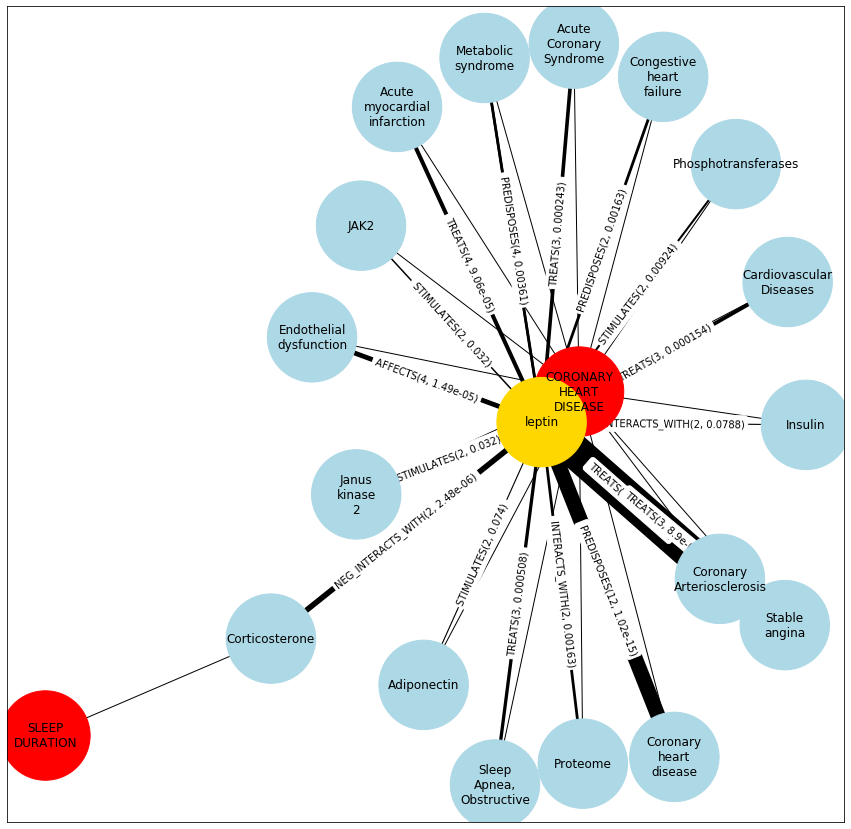

In [17]:
pos = graphviz_layout(G)
plt.figure(figsize=(15, 15))
nx.draw_networkx_edges(G, pos, edgelist=edgelist, width=edges["weight"].tolist())
nx.draw_networkx_nodes(
    G, pos, nodelist=nodes["node"].tolist(), node_size=8000, node_color=node_colors
)
_ = nx.draw_networkx_edge_labels(G, pos, edge_labels)
_ = nx.draw_networkx_labels(G, pos, node_labels)
plt.savefig(f"{focus_term}.png")

## Checking the source literature

We can refer back to the articles to check the text that was used to derive the SemMedDB data. This is important due to the imperfect nature of the SemRep annotation process (https://semrep.nlm.nih.gov/). 

In [18]:
def get_literature(gwas_id, triple_id):
    endpoint = "/literature/gwas"
    url = f"{API_URL}{endpoint}"
    params = {
        "gwas_id": gwas_id,
        "semmed_triple_id": triple_id,
        "by_gwas_id": "true",
        "pval_threshold": 1e-1,
    }
    r = requests.get(url, params=params)
    r.raise_for_status()
    df = pd.json_normalize(r.json()["results"])
    if len(df) > 0:
        res = {
            "triple_name": df["triple.name"].drop_duplicates().tolist(),
            "pubmed_id": df["lit.id"].tolist(),
        }
        return res


gwas_pub_df = pd.concat(
    [
        lit_detail.rename(columns={"gwas.id": "gwas_id", "s1.id": "triple_id"})[
            ["gwas_id", "triple_id"]
        ]
        .drop_duplicates()
        .assign(
            literature_epigraphdb=lambda df: df.apply(
                lambda row: get_literature(row["gwas_id"], row["triple_id"]), axis=1
            )
        ),
        lit_detail.rename(columns={"assoc_gwas.id": "gwas_id", "s2.id": "triple_id"})[
            ["gwas_id", "triple_id"]
        ]
        .drop_duplicates()
        .assign(
            literature_epigraphdb=lambda df: df.apply(
                lambda row: get_literature(row["gwas_id"], row["triple_id"]), axis=1
            )
        ),
    ]
).reset_index(drop=True)
gwas_pub_df

,gwas_id,triple_id,literature_epigraphdb
0,ieu-a-1088,C0010124:NEG_INTERACTS_WITH:C0299583,{'triple_name': ['Corticosterone NEG_INTERACTS...
1,ieu-a-6,C0299583:TREATS:C0520679,{'triple_name': ['Leptin|LEP TREATS Sleep Apne...
2,ieu-a-6,C0299583:STIMULATES:C0031727,{'triple_name': ['Leptin STIMULATES Phosphotra...
3,ieu-a-6,C0299583:STIMULATES:3717,{'triple_name': ['Leptin|LEP STIMULATES Janus ...
4,ieu-a-6,C0299583:STIMULATES:C0169661,{'triple_name': ['Leptin|LEP STIMULATES Janus ...
5,ieu-a-6,C0299583:INTERACTS_WITH:C0021641,{'triple_name': ['Leptin INTERACTS_WITH Insuli...
6,ieu-a-6,C0299583:STIMULATES:C0389071,{'triple_name': ['Leptin STIMULATES Adiponecti...
7,ieu-a-6,C0299583:PREDISPOSES:C0010068,{'triple_name': ['Leptin|LEP PREDISPOSES Coron...
8,ieu-a-6,C0299583:INTERACTS_WITH:C0751973,{'triple_name': ['Leptin|LEP INTERACTS_WITH Pr...
9,ieu-a-6,C0299583:CAUSES:C0856169,{'triple_name': ['Leptin|LEP CAUSES Endothelia...


## Check the text

Do the data from SemMedDB match the literature origins? Here we can use the MELODI Presto API (http://melodi-presto.mrcieu.ac.uk/docs/) to examine the SemMedDB data in more detail.

In [19]:
def get_sentence_data(pmid):
    url = "https://melodi-presto.mrcieu.ac.uk/api/sentence/"
    params = {
        "pmid": pmid,
    }
    response = requests.post(url, data=json.dumps(params))
    response.raise_for_status()
    res = response.json()["data"]
    df = pd.json_normalize(res)
    if len(df) > 0:
        return df["SENTENCE"].drop_duplicates().tolist()


max_items = 5
for idx, data in gwas_pub_df.head(max_items).iterrows():
    print("\n###", data["literature_epigraphdb"]["triple_name"], " ###\n")
    sentence_results = [
        get_sentence_data(_) for _ in data["literature_epigraphdb"]["pubmed_id"]
    ]
    # flatten
    sentence_results = [_ for sublist in sentence_results for _ in sublist]
    for _ in sentence_results:
        print(_, "\n")


### ['Corticosterone NEG_INTERACTS_WITH Leptin|LEP']  ###



Interestingly, such changes were associated with increased serum levels of glucagon, corticosterone, and norepinephrine, but no effects on leptin, insulin, or ghrelin were observed. 

SD failed to change leptin concentrations, but it promptly stimulated plasma ghrelin and induced eating. 

SD increased plasma corticosterone, but corticosterone did not seem to influence either leptin or ghrelin. 


### ['Leptin|LEP TREATS Sleep Apnea, Obstructive']  ###



BACKGROUND: Obstructive sleep apnea syndrome (OSAS) is a common disorder in obese subjects. 

Changes in intra-abdominal visceral fat and serum leptin levels in patients with obstructive sleep apnea syndrome following nasal continuous positive airway pressure therapy. 

Serum leptin levels of another 21 OSAS patients were measured before and after 3 to 4 days of NCPAP to gain insight into the mechanism by which NCPAP affects fat distribution. 

The effect of nasal continuous positive airway pressure (NCPAP) treatment on VFA and serum leptin levels in OSAS patients has not been known. 

BACKGROUND: Obstructive sleep apnea syndrome (OSAS) is a common disorder in obese subjects. 

Changes in intra-abdominal visceral fat and serum leptin levels in patients with obstructive sleep apnea syndrome following nasal continuous positive airway pressure therapy. 

Serum leptin levels of another 21 OSAS patients were measured before and after 3 to 4 days of NCPAP to gain insight into the mechanism b

These effects of leptin on [Ca(2+)](i) were inhibited by blockers of JAK2 and tyrosine kinases. 

It has been reported that leptin is an independent risk factor for the coronary artery disease in obese patients and that leptin is involved in the pathogenesis of cardiovascular diseases. 

Leptin potentiates ADP-induced [Ca(2+)](i) increase via JAK2 and tyrosine kinases in a megakaryoblast cell line. 

The results indicate that leptin enhances ADP-induced [Ca(2+)](i) increases via JAK2 and tyrosine kinases in a megakaryoblast cell line. 

Plasma leptin levels are elevated in most of obese individuals, and obesity is associated with high incidence of cardiovascular diseases. 


### ['Leptin|LEP STIMULATES Janus kinase 2|JAK2']  ###



These effects of leptin on [Ca(2+)](i) were inhibited by blockers of JAK2 and tyrosine kinases. 

It has been reported that leptin is an independent risk factor for the coronary artery disease in obese patients and that leptin is involved in the pathogenesis of cardiovascular diseases. 

Leptin potentiates ADP-induced [Ca(2+)](i) increase via JAK2 and tyrosine kinases in a megakaryoblast cell line. 

The results indicate that leptin enhances ADP-induced [Ca(2+)](i) increases via JAK2 and tyrosine kinases in a megakaryoblast cell line. 

Plasma leptin levels are elevated in most of obese individuals, and obesity is associated with high incidence of cardiovascular diseases. 


### ['Leptin|LEP STIMULATES Janus kinase 2|JAK2']  ###



These effects of leptin on [Ca(2+)](i) were inhibited by blockers of JAK2 and tyrosine kinases. 

It has been reported that leptin is an independent risk factor for the coronary artery disease in obese patients and that leptin is involved in the pathogenesis of cardiovascular diseases. 

Leptin potentiates ADP-induced [Ca(2+)](i) increase via JAK2 and tyrosine kinases in a megakaryoblast cell line. 

The results indicate that leptin enhances ADP-induced [Ca(2+)](i) increases via JAK2 and tyrosine kinases in a megakaryoblast cell line. 

Plasma leptin levels are elevated in most of obese individuals, and obesity is associated with high incidence of cardiovascular diseases. 

